<a href="https://colab.research.google.com/github/PriyankaTUI/AudioClassificationWithDeepLearningAnalysis/blob/master/spoken_digit_rcognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/PriyankaTUI/AudioClassificationWithDeepLearningAnalysis.git
%cd AudioClassificationWithDeepLearningAnalysis
!pwd

Cloning into 'AudioClassificationWithDeepLearningAnalysis'...
remote: Enumerating objects: 80, done.
remote: Counting objects: 100% (80/80), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 80 (delta 33), reused 28 (delta 5), pack-reused 0
Unpacking objects: 100% (80/80), done.
/content/AudioClassificationWithDeepLearningAnalysis
/content/AudioClassificationWithDeepLearningAnalysis


In [2]:
import numpy as np
import torch
import models
import copy
import torch.nn.functional as F
import torchaudio
import torch.nn as nn
from torch.utils.data import DataLoader,random_split,Dataset
from torchsummary import summary
import torchvision
import torch.utils.tensorboard as tb
import matplotlib.pyplot as plt


In [3]:
#load tensorboard to monitor training
%load_ext tensorboard

writer = tb.SummaryWriter()

def label_to_index(labels, label):
    # Return the position of the word in labels
    return torch.tensor(labels.index(label))

def index_to_label(labels, index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]

class SpeechCommandSubDataset(Dataset):
    
    def __init__(self,data,labels):
        self.data = data
        self.labels = labels
            
    def __len__(self):
        return len(self.data)    
    
    def __getitem__(self,idx):
        return self.data[idx], self.labels[idx]

In [4]:
#Loading dataset and custom dataloader
dataset = torchaudio.datasets.SPEECHCOMMANDS('./dataset/data/' , url = 'speech_commands_v0.02', folder_in_archive= 'SpeechCommands',  download = True)
digits = ['zero','one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine'] 

tensors = []
targets = []

#parameters for MFCC transformation
n_fft = 2048
win_length = None
hop_length = 512
n_mels = 256
n_mfcc = 256

for waveform, sample_rate, label, *_ in dataset:
  if label in digits:
    if sample_rate == 16000:
      if waveform.shape == (1, 16000):
        tensors += [torchaudio.transforms.MFCC(sample_rate=sample_rate, n_mfcc=32, 
                                               melkwargs={
                                                            'n_fft': n_fft,
                                                            'n_mels': n_mels,
                                                            'hop_length': hop_length,
                                                            'mel_scale': 'htk',
                                                          }
                                                          )(waveform)]
        targets += [label_to_index(digits, label)]

valid_dataset = SpeechCommandSubDataset(data = tensors, 
                                        labels = targets)

traindata, testdata = random_split(valid_dataset, [round(len(valid_dataset)*.6), round(len(valid_dataset)*.4)])
trainloader = DataLoader(traindata, batch_size=10, shuffle=True)
testloader = DataLoader(testdata, batch_size=10, shuffle=True)

  0%|          | 0.00/2.26G [00:00<?, ?B/s]

(array([3756., 3492., 3525., 3402., 3403., 3727., 3598., 3668., 3429.,
        3628.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

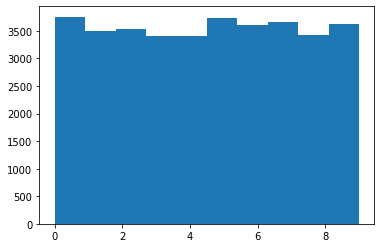

In [6]:
#visualization of dataset
temp_dataset = [targets[index].item() for index in range(len(targets))]
plt.hist(temp_dataset, bins=10)

In [ ]:
print("Initializing the neural network...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.cnnModel().to(device)

# Loss function and optimizer
# loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
best_accuracy = 0.0
print("Started training !")
for epoch in range(201):
  running_loss = []
  for i, (inputs, labels) in enumerate(trainloader): 
    optimizer.zero_grad()
    logits = model(inputs) #batch_size x 14
    loss = F.cross_entropy(logits, labels)
    loss.backward() 
    optimizer.step()
    running_loss.append(loss.item())

  print(f'[epoch {epoch}] loss: {sum(running_loss)/len(running_loss)}')

  # Evaluate the model on the test set every 10 epochs
  if epoch % 10 == 0:
      accuracy, accuracies = evaluate_model(model, X_test, y_test)
      print('accuracy', accuracy)
      print('accuracies', accuracies)
      # Saving model if accuracy on the test set is better than previous best model
      if accuracy > best_accuracy:
          best_accuracy = accuracy
          torch.save(model.state_dict(), 'best_model_state.pt')
          print("Best model saved")